# Notebook to clean up and parse eldenring wiki data


In [1]:
%matplotlib inline

In [2]:
from bs4 import BeautifulSoup
import re
from fastcore.foundation import L
from matplotlib import pyplot as plt
from fastcore.basics import groupby, itemgetter

# Load the HTML content from a file
html_file_path = '/Users/cck/Desktop/elden_ring_dialogue.html'
with open(html_file_path, 'r', encoding='utf-8') as file:
    html_content = file.read()

# Parse the HTML
soup = BeautifulSoup(html_content, 'html.parser')


In [3]:

# Find the "TalkMsg.fmg" section
talk_msg_section = soup.find('h2', string='TalkMsg.fmg')


In [4]:

# Initialize a list to hold the extracted paragraphs
extracted_paragraphs = L()

# Regular expression pattern to find and remove brackets and their contents
pattern = r'\[\d+\]\s*'

def clean_text(text):
    # Use re.sub() to replace the pattern with an empty string
    cleaned_text = re.sub(pattern, '', text)
    cleaned_text = cleaned_text.strip()
    return cleaned_text


def text_is_empty(text):
    return text in ('', ' ', '\n')


def is_name_just_digits(speaker_name):
    return re.fullmatch(r'\d+', speaker_name) is not None


entries = L()

# Start extracting from the found header
current_tag = talk_msg_section.next_sibling
current_speaker = None
current_turn = None

while current_tag:
    if current_tag.name == 'h3':
        current_speaker = current_tag.text
        current_speaker = clean_text(current_speaker)
    elif current_tag.name == 'h4':
        current_turn = current_tag.text
    elif current_tag.name == 'p':
        # Remove brackets and their contents
        text = current_tag.get_text(" ", strip=True)
        text = clean_text(text)
        if not text_is_empty(text):
            entry = {
                'words': text,
                'speaker': current_speaker,
                'turn': current_turn,
            }
            entries.append(entry)
    
    current_tag = current_tag.next_sibling if current_tag.next_sibling else None

# the first entry is garbage
entries = entries[1:]

# clean up digit-only names
entries = entries.filter(lambda x: (x['speaker'] and not is_name_just_digits(x['speaker'])))

In [5]:
len(entries)

2270

In [6]:
entries[5]

{'words': 'Phew. It is done.', 'speaker': 'Melina', 'turn': 'Section 22'}

In [7]:
# group the speakers together
by_speaker = groupby(entries, itemgetter('speaker'))

In [8]:
# counts up words by speaker
def count_words(entries):
    return sum(len(entry['words'].split()) for entry in entries)

In [9]:
# find how much each speaker says
speaker_counts = {speaker: count_words(entries) for speaker, entries in by_speaker.items()}

# sort the speakers by how much they talk
speaker_counts_sorted = dict(sorted(speaker_counts.items(), key=itemgetter(1), reverse=True))

In [10]:
by_speaker['Baleful Shadow']

[{'words': "Oh, it's you... It's me, Blaidd. Old Iji trapped me here. Told me I'd bring nought but bale to Lady Ranni. But there's no chance that could happen. I'm part of her being. Her very shadow... I thought old Iji knew as much... Honestly, I don't know what's going on anymore...",
  'speaker': 'Baleful Shadow',
  'turn': 'Section 00'},
 {'words': "I don't understand. Why would Iji do this... I could never intend harm to Lady Ranni. What's he thinking...",
  'speaker': 'Baleful Shadow',
  'turn': 'Section 01'},
 {'words': "My thanks, friend. I'm going to see mistress Ranni, now. I don't know what came over old Iji, but even if the odds are slim, I need to check the mistress is safe. Now, Ranni can finally set in motion the fight against her fate she's dreamt of for so long.",
  'speaker': 'Baleful Shadow',
  'turn': 'Section 10'},
 {'words': "I'm going to see mistress Ranni, now. I don't know what came over old Iji, but even if the odds are slim, I need to check the mistress is sa

In [19]:
speaker_counts_sorted

{'Sir Gideon Ofnir, the All-Knowing': 2553,
 'Alexander, Warrior Jar': 2270,
 'Sorcerer Rogier': 1663,
 'Preceptor Seluvis': 1656,
 'Rya the Scout': 1588,
 'White Mask Varré': 1556,
 'Roderika, Spirit Tuner': 1479,
 'Scribe Corhyn': 1445,
 'Jar-Bairn': 1403,
 'Merchant Kalé': 1372,
 'War Counselor Iji': 1350,
 'Sage Gowry': 1303,
 'Shabriri': 1290,
 'Tanith, Volcano Manor Proprietress': 1272,
 'Patches': 1245,
 'Demi-Human Boc': 1242,
 'Irina of Morne': 1182,
 'D, Hunter of the Dead': 1176,
 'Fia, Deathbed Companion': 1173,
 'Sorceress Sellen': 1166,
 'Blaidd the Half-Wolf': 1145,
 'Renna the Witch': 1129,
 'Kenneth Haight, Limgrave Heir': 1036,
 'Millicent': 1023,
 'Potentate Diallos': 957,
 'Miriel, Pastor of Vows': 946,
 'Finger Reader Enia': 920,
 'Reeling Rico': 911,
 'Recusant Bernahl': 871,
 'Nepheli Loux, Warrior': 868,
 'Witch-Hunter Jerren': 779,
 'Sorcerer Thops': 728,
 'Latenna the Albinauric': 675,
 'Remembrance Duplication Menu': 621,
 'Blackguard': 607,
 'Gatekeeper Gost

In [20]:
CUTOFF = 99
valid_speakers = L(spkr for spkr, count in speaker_counts_sorted.items() if count >= 100); valid_speakers

(#47) ['Sir Gideon Ofnir, the All-Knowing','Alexander, Warrior Jar','Sorcerer Rogier','Preceptor Seluvis','Rya the Scout','White Mask Varré','Roderika, Spirit Tuner','Scribe Corhyn','Jar-Bairn','Merchant Kalé'...]

In [21]:
valid_entries = L(entry for entry in entries if entry['speaker'] in valid_speakers); valid_entries

(#1296) [{'words': 'Have you heard of the Finger Maidens? They serve the Two Fingers, offering guidance, and aid, to the Tarnished. But you, I am afraid, are maidenless. I can play the role of maiden. Turning runes into strength. To aid you in your search for the Elden Ring. You need only take me with you. To the foot of the Erdtree.', 'speaker': 'Melina', 'turn': 'Section 10'},{'words': "Then it's settled. Summon me by grace to turn runes into strength. Ahh, another matter. I bequeath to you this ring. Use it to traverse great distances. It will summon a spectral steed named Torrent. Torrent has chosen you. Treat him with respect.", 'speaker': 'Melina', 'turn': 'Section 11'},{'words': "I understand. I'm asking you to put faith in but a stranger. Yet I'm certain that we can reach an understanding. Summon me by grace if you should reconsider.", 'speaker': 'Melina', 'turn': 'Section 12'},{'words': 'Have you reconsidered my offer?', 'speaker': 'Melina', 'turn': 'Section 13'},{'words': 'Sh

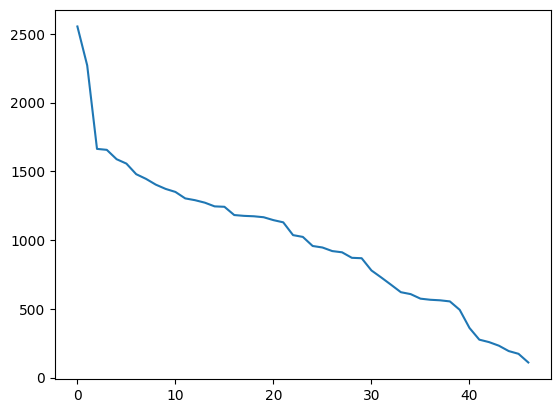

In [22]:
plt.plot([speaker_counts_sorted[spkr] for spkr in valid_speakers])

In [31]:
valid_data = {spkr: vals for spkr, vals in by_speaker.items() if spkr in valid_speakers}

In [32]:
top_spkrs = L(valid_speakers[:3])
name = top_spkrs[0]

In [33]:
print(
    '\n'.join(
        o['words'] 
        for o in valid_data[valid_speakers[2]]
    )
)

Ah, nice to meet you. The pleasure's mine. Rogier's the name. A sorcerer, as you might have guessed. I'm looking for a little something, here in the castle. When I'm not hotfooting it from the troops, that is. But enough about me, what are you doing here in Stormveil Castle? This place is bristling with Tarnished hunters, you know. They sacrifice our kind, for grafting. Not exactly a place I'd stroll into without a purpose in mind...
I see. Here to challenge Godrick, and lay your hands upon a Great Rune, are you? You can see it then, I take it? The guidance of grace. Well, enjoy it while you can. I'm Tarnished, like you. But unlike you, I've seen neither hide nor hair of this guidance for the longest time. Still, I won't forget how it felt when I first came here, to the Lands Between. I'm privy to a few magical battle arts. Would you care to learn one? As a fellow Tarnished, once guided by grace. I'd love to help you out, if it please.
Oh? Keen to learn another battle art, are we?
Oh h

In [37]:
# sort the speaker's text by their length
valid_data = {
    spkr: sorted(
        vals, 
        key=lambda x: len(x['words'].split()), 
        reverse=True
    ) 
    for spkr, vals in valid_data.items()
}

In [40]:
valid_data[valid_speakers[10]]

[{'words': "Jerren. Now, that's a name I haven't heard for a while. Before taking up the banner of General Radahn, he was a guest of the Carian royal family. An expert swordsman, to be sure, but ever the eccentric. No surprise he'd get wrapped up in some festival. Oh, no, wait... How did I not see it before! I ought to retire as war counsellor for such a gross oversight! Let me explain. The fate of the Carian royal family is guided by the stars. As is the fate of Lady Ranni, first heir in the Carian royal line. But General Radahn is the conqueror of the stars. Who stood up to the swirling constellations, halting their movement in a smashing victory. And so, if General Radahn were defeated, the stars would once again resume their movement. As would Lady Ranni's destiny. Perhaps, even, revealing the elusive path. That leads to Nokron.",
  'speaker': 'War Counselor Iji',
  'turn': 'Section 32'},
 {'words': "Brave Tarnished. A word of warning, if you please. This territory once belonged to